In [1]:
import collections
import functools
import itertools
import re
import string
from timeit import default_timer
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import DictVectorizer
from wordcloud import WordCloud

from sm_analysis.utils import *
from sm_analysis.graph import *
from sm_analysis.time_series import *
from sm_analysis.topic_modeling import *
from sm_analysis.twitter import *

In [2]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer

# suppress stop words mismatch warning
warnings.simplefilter('ignore')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/skp340/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Text processing

## Pipeline:
We are starting with a series of strings representing individual tweets. Hashtags and urls are in a separate column, as a list of strings. We perform our analysis on
- individual tweets;
- all tweets for a grouping of the dataframe (e.g. group by userid); and,
- all tweets in the corpus.

Utility functions anticipate tokenizing for these levels of analysis.

## Preprocessing:
1. Remove uninformative symbols
1. Remove 'RT'
1. Replace urls, hashtags, and @-mentions with generic tokens
1. Remove stopwords
1. Lemmatize

In [3]:
users = UsersData('data/users')
tweets = TweetsData('data/tweets')
df = tweets.df.loc[:][:]
user_df = users.df.loc[:][:]
campaign = df[df['campaign'] == 'iran202012']
campaign_users = user_df[user_df['campaign'] == 'iran202012']

Define aggregation for tweet text as joining tweet strings into a list of strings:

In [4]:
string_agg = lambda x: list(x)

user_tweets = (campaign
               .groupby('userid')[['tweet_text']]
               .agg(string_agg)
              )
user_tweets.head()

,tweet_text
userid,
+JkWMulEtCyTrcFDRO2XLv9EOdGHDl0GB9cdZUWgtA=,[America and the way its government treats its...
+fwTi4Wv1fs5sua3wZXqtBWBMMAy5IKNd5euWlP8Kuk=,[@ManotoNews اگه ایران به یمن و مقاومت کمک نکن...
0gTQ2cDCHFpYXKO+G367F1HBrPLupiuPjXuvmp9UL+w=,[People are not silent! This structure must ch...
0hVjtURHlBEHZhn22rNDf98r+8VUXV3gi1bxvAhrZo=,[El pueblo indígena Kayapo cerró una important...
0zCl5U0pYu0gEmK3JtjO5fbnxEj6pO9GUgH52Q6yg0E=,[@VoteMarsha Why Women Prefer to Vote for an r...


### Pipeline usage

Aggregate all tweets for each user to characterize users by the overall contents of their activity:

In [5]:
def make_tokens(list_of_strings,
                stop_words=[*stopwords.words(),
                          '[URL]', '[AT]', '[HTAG]'],
                timer=False):
    """Apply preprocessing and tokenization to a list of strings.
    Usage: 
            output = make_tokens(series_of_strings)

            output = df.apply(make_tokens)
            
    Return:
        A list of lists of tokens for each string.
    """   
    if timer:
        t1 = default_timer()

    processed_strings = [preprocess_string(string)
                         for string in list_of_strings]

    tokenized_strings = [tokenize_string(string,
                                         stop_words)
                          for string in processed_strings]
                         
    if timer:
        t2 = default_timer()
        print('elapsed', t2 - t1)
    
    return tokenized_strings

In [6]:
(user_tweets['tweet_text'].head(1)
               .map(make_tokens))

userid
+JkWMulEtCyTrcFDRO2XLv9EOdGHDl0GB9cdZUWgtA=    [[america, government, treats, reformed], [], ...
Name: tweet_text, dtype: object

In [7]:
user_tokens = (user_tweets['tweet_text']
               .map(make_tokens)
               .map(long_list))

elapsed 0.055857357001514174
elapsed 0.05654010699072387
elapsed 0.24476642100489698
elapsed 0.8237686310021672
elapsed 6.842225551998126
elapsed 6.729245187001652
elapsed 3.55467160801345
elapsed 1.4509437480010092
elapsed 6.3862754910078365
elapsed 0.5672768030053703
elapsed 0.1356646940112114
elapsed 144.2105203490064
elapsed 0.25270523900690023
elapsed 0.28750412398949265
elapsed 0.13495390399475582
elapsed 0.168164450005861
elapsed 0.04617652899469249
elapsed 0.02214931999333203
elapsed 0.001993281999602914
elapsed 0.33809376500721555
elapsed 0.7705189659900498
elapsed 0.38000779000867624
elapsed 0.8536394109978573
elapsed 0.0034832189994631335
elapsed 3.4491667109978152
elapsed 0.037463216998730786
elapsed 1.8169638239924097
elapsed 3.4567111889919033
elapsed 0.052870272993459366
elapsed 0.0008810709987301379
elapsed 0.06784817700099666
elapsed 0.17094479899969883
elapsed 0.1440525469952263
elapsed 0.7406970849988284
elapsed 0.18696253799134865
elapsed 0.011015625001164153
elapse

In [8]:
print(user_tokens[:10])

userid
+JkWMulEtCyTrcFDRO2XLv9EOdGHDl0GB9cdZUWgtA=     [america, way, government, treats, people, mus...
+fwTi4Wv1fs5sua3wZXqtBWBMMAy5IKNd5euWlP8Kuk=    [اگه, ایران, یمن, مقاومت, کمک, نکنه, خاک, تو, ...
0gTQ2cDCHFpYXKO+G367F1HBrPLupiuPjXuvmp9UL+w=    [people, silent, structure, must, change, hell...
0hVjtURHlBEHZhn22rNDf98r+8VUXV3gi1bxvAhrZo=     [pueblo, indígena, kayapo, cerró, impoante, ca...
0zCl5U0pYu0gEmK3JtjO5fbnxEj6pO9GUgH52Q6yg0E=    [women, prefer, vote, rapest, pedophile, reall...
1067814896706994176                             [bentuk, rasionalitas, islam, ketiadaan, bentu...
1091795789263921152                             [اگه, امشب, مولانا, توییتر, میومد, از, همه, مو...
1099221870530961408                             [droit, vote, ans, pourquoi, quoi, neuf, rasse...
1235289416370774016                             [trump, realized, loser, election, keep, pleas...
1273528131861782528                             [trumps, ruined, country, reelected, country, ...
Name: tweet_t

## Word frequencies

In [9]:
def word_frequency(list_of_words):
    """
    Return:
        dict of {'word':'frequency'}
    """
    counts = collections.Counter(list_of_words)
    
    return dict(sorted(counts.items(), key=lambda item: item[1], reverse=True))

In [10]:
freq_dicts = (user_tokens
            .apply(word_frequency)
            )
freq_dicts

userid
+JkWMulEtCyTrcFDRO2XLv9EOdGHDl0GB9cdZUWgtA=     {'trump': 23, 'corona': 9, 'lies': 6, 'america...
+fwTi4Wv1fs5sua3wZXqtBWBMMAy5IKNd5euWlP8Kuk=    {'که': 48, 'از': 42, 'در': 40, 'با': 26, 'این'...
0gTQ2cDCHFpYXKO+G367F1HBrPLupiuPjXuvmp9UL+w=    {'trump': 116, 'people': 45, 'vote': 35, 'us':...
0hVjtURHlBEHZhn22rNDf98r+8VUXV3gi1bxvAhrZo=     {'eeuu': 299, 'policía': 174, 'venezuela': 162...
0zCl5U0pYu0gEmK3JtjO5fbnxEj6pO9GUgH52Q6yg0E=    {'silver': 9486, 'biden': 7030, 'price': 4722,...
                                                                      ...                        
y3KkURpZFjT+WeW9e6BcxBYRg311F8fz1eJ647ahQc=     {'trump': 146, 'president': 34, 'people': 34, ...
z3nCVBEHiIbcBhhxU2mOz5iWK4a7sUdGmRSPFM16G0=     {'yang': 1812, 'palestina': 1606, 'israel': 10...
zFlH+vHUhiZD2qvvCLYyiU76qOha9+iYxCn1NVmzw=      {'nothing': 5, 'twitter': 4, 'biden': 4, 'trum...
zTUtu8WZ3RwxnwgMsYXnTU107UXsn4MQU5wrg8IDOU=     {'sick': 1, 'tired': 1, 'lied': 1, 'amazing': ...
zk4khaX7A3XhX

In [38]:
vectorizer = DictVectorizer(sparse=True)
tf = vectorizer.fit_transform(freq_dicts)

In [14]:
corpus_freq_dict = word_frequency(long_list(user_tokens))
print(list(zip(corpus_freq_dict.keys(), corpus_freq_dict.values()))[:20])

[('via', 40982), ('completa', 25234), ('trump', 22582), ('irán', 18853), ('eeuu', 18729), ('yang', 18359), ('از', 15338), ('video', 14312), ('که', 14106), ('در', 13904), ('historia', 13126), ('israel', 12269), ('nota', 11551), ('presidente', 11395), ('people', 11139), ('palestina', 9959), ('gobierno', 9752), ('silver', 9506), ('biden', 9431), ('را', 8810)]


In [15]:
top_user = (campaign
           .groupby('userid')
           .size()
           .idxmax())
top_user_tokens = user_tokens.loc[top_user]
print(top_user_tokens[:20])

['quedan', 'episodios', 'final', 'serie', 'profeta', 'josé', 'días', 'gmt', 'repite', 'nicaragua', 'país', 'seguro', 'centroamérica', 'competencia', 'militares', 'israelíes', 'matar', 'palestinos', 'construcción', 'empresa']


In [16]:
document_freq_dict = word_frequency(top_user_tokens)
print('Vocabulary size: {}'.format(len(document_freq_dict)))

Vocabulary size: 62325


## Word cloud

In [17]:
def visualize(data,
              from_frequencies=True,
              limit=100,
              color=(150,50,50)):
    """
    """
    cloud = WordCloud(background_color="white",
                  prefer_horizontal=0.9,
                  max_font_size=40,
                  relative_scaling=.5,
                  color_func=lambda *args,**kwargs:color)
    
    data = dict(sorted(data.items(), key=lambda item: item[1], reverse=True)[:limit])
        
    if from_frequencies:
        cloud.generate_from_frequencies(data)
    else:
        cloud.generate(data)
    
    fig, ax = plt.subplots()
    ax.imshow(cloud)
    ax.axis('off')
    
    return fig

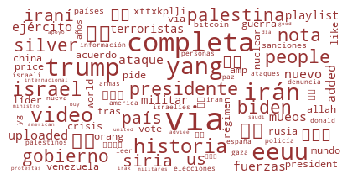

In [18]:
fig = visualize(corpus_freq_dict)

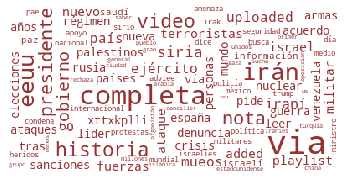

In [19]:
fig = visualize(document_freq_dict)

### Hashtag frequency + word cloud

In [20]:
hashtags = (campaign
               .loc[:]['hashtags']
               .fillna('')
               )
hashtag_list = [el.strip() for el in long_list(hashtags)
               if el != '']
hashtag_freq = word_frequency(hashtag_list)

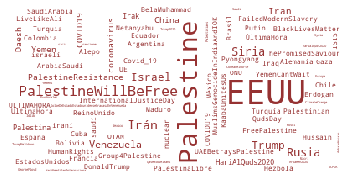

In [21]:
fig = visualize(hashtag_freq)

In [22]:
print('Unique hashtags: {}'.format(len(hashtag_freq)))

Unique hashtags: 37964


## Vectorizing

Using sklearn's Vectorizers to turn the corpus into a text-term matrix allows us to easily count tokens, and count n-grams as well as single-word tokens.

In [23]:
stop_words = [*stopwords.words(),
              '[url]', '[at]', '[htag]',
             ]
tokenize_partial = functools.partial(tokenize_string, stop_words=stop_words)
preprocess_partial = functools.partial(preprocess_string, special_tokens=False)

In [24]:
vectorizer = CountVectorizer(analyzer='word',
                             strip_accents='ascii',
                             stop_words=stop_words,
                             ngram_range=(1,2),
                             preprocessor=preprocess_partial,
                             tokenizer=tokenize_partial,
                            )

documents_list = (user_tweets['tweet_text']
                    .map(long_string)
                   )

In [25]:
print(documents_list[:5])

userid
+JkWMulEtCyTrcFDRO2XLv9EOdGHDl0GB9cdZUWgtA=     America and the way its government treats its ...
+fwTi4Wv1fs5sua3wZXqtBWBMMAy5IKNd5euWlP8Kuk=    @ManotoNews اگه ایران به یمن و مقاومت کمک نکنه...
0gTQ2cDCHFpYXKO+G367F1HBrPLupiuPjXuvmp9UL+w=    People are not silent! This structure must cha...
0hVjtURHlBEHZhn22rNDf98r+8VUXV3gi1bxvAhrZo=     El pueblo indígena Kayapo cerró una importante...
0zCl5U0pYu0gEmK3JtjO5fbnxEj6pO9GUgH52Q6yg0E=    @VoteMarsha Why Women Prefer to Vote for an ra...
Name: tweet_text, dtype: object


In [26]:
# tokenize + construct the frequency matrix from tokens
matrix = vectorizer.fit_transform(documents_list)

In [27]:
# get token names + frequencies
ngrams = vectorizer.get_feature_names()
ngram_frequencies = matrix.sum(axis=0).tolist()[0]
freq_dict = dict(zip(ngrams, ngram_frequencies))

In [30]:
matrix

<209x2578062 sparse matrix of type '<class 'numpy.int64'>'
	with 3448425 stored elements in Compressed Sparse Row format>

In [29]:
print(sorted(freq_dict.items(), key=lambda item: item[1], reverse=True)[:20])

[('via', 40982), ('completa', 25234), ('trump', 22582), ('irán', 18853), ('eeuu', 18729), ('yang', 18359), ('از', 15338), ('video', 14312), ('که', 14106), ('در', 13904), ('historia', 13126), ('israel', 12269), ('historia completa', 12192), ('nota', 11551), ('nota completa', 11445), ('presidente', 11395), ('people', 11139), ('palestina', 9959), ('gobierno', 9752), ('silver', 9506)]


# Topic extraction

Tutorial: https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html#

In [31]:
# suggested scale
n_samples = 2000
n_features = 1000
n_components = 10
n_top_words = 20

stop_words = [*stopwords.words(),
              '[url]', '[at]', '[htag]',]
tokenize_partial = functools.partial(tokenize_string, stop_words=stop_words)
preprocess_partial = functools.partial(preprocess_string, special_tokens=False)

vectorizer = CountVectorizer(analyzer='word',
                             strip_accents='ascii',
                             stop_words=stop_words,
                             ngram_range=(1,2),
                             preprocessor=preprocess_partial,
                             tokenizer=tokenize_partial,
                            )

## Latent Dirichlet Allocation (LDA)

Latent Dirichlet Allocation is a generative probabilistic model which models a corpus as a random mixture of topics and uses the observed words to fit latent variables describing the mixture of topics and the distribution of words in the documents of the corpus.

A corpus consists of $D$ documents ($\sim$vector samples) of $N$ words ($\sim$entry samples) described by $K$ topics ($\sim$classes).

1. For each topic $k \in K$, draw $\beta_{k} \sim \text{Dirichlet}(\eta)$. This represents the probability of a word appearing in topic $k$.


1. For each document $d \in D$: draw the topic proportions $\theta_{d} \sim \text{Dirichlet}(\alpha).$

1. For each word $i$ in document $D$:
    1. Draw the topic assignment $z_{di} \sim \text{Multinomial}(\theta_{d})$
    2. Draw the observed word $w_{ij} \sim \text{Multinomial}(\beta_{z_{di}})$

For parameter estimation, the posterior distribution is:
$$
p(z,\theta,\beta\mid w,\alpha,\eta) = \frac{p(z,\theta,\beta\mid\alpha,\eta)}{p(w\mid\alpha,\eta)}
$$

Variational Bayesian method uses a simpler distribution to approximate the posterior distribution and optimizes parameters in an expectation-minimization procedure. Variational parameters are optimized to maximize the Evidence Lower Bound (ELBO) - maximizing ELBO is equivalent to minimizing the Kullback-Leibler (KL) divergence between the estimate $q$ and the true posterior $p$.

In [32]:
t1 = default_timer()

tf = vectorizer.fit_transform(documents_list)

t2 = default_timer()

print('elapsed: {}'.format(t2 - t1))

elapsed: 66.49930043199856


In [33]:
print(('n_samples: {}\nn_features: {}')
      .format(n_samples, n_features))

lda = LatentDirichletAllocation(n_components=n_components, 
                                max_iter=5,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)
t1 = default_timer()

lda.fit(tf)

t2 = default_timer()

print('elapsed: {}'.format(t2 - t1))

n_samples: 2000
n_features: 1000
elapsed: 81.1301295519952


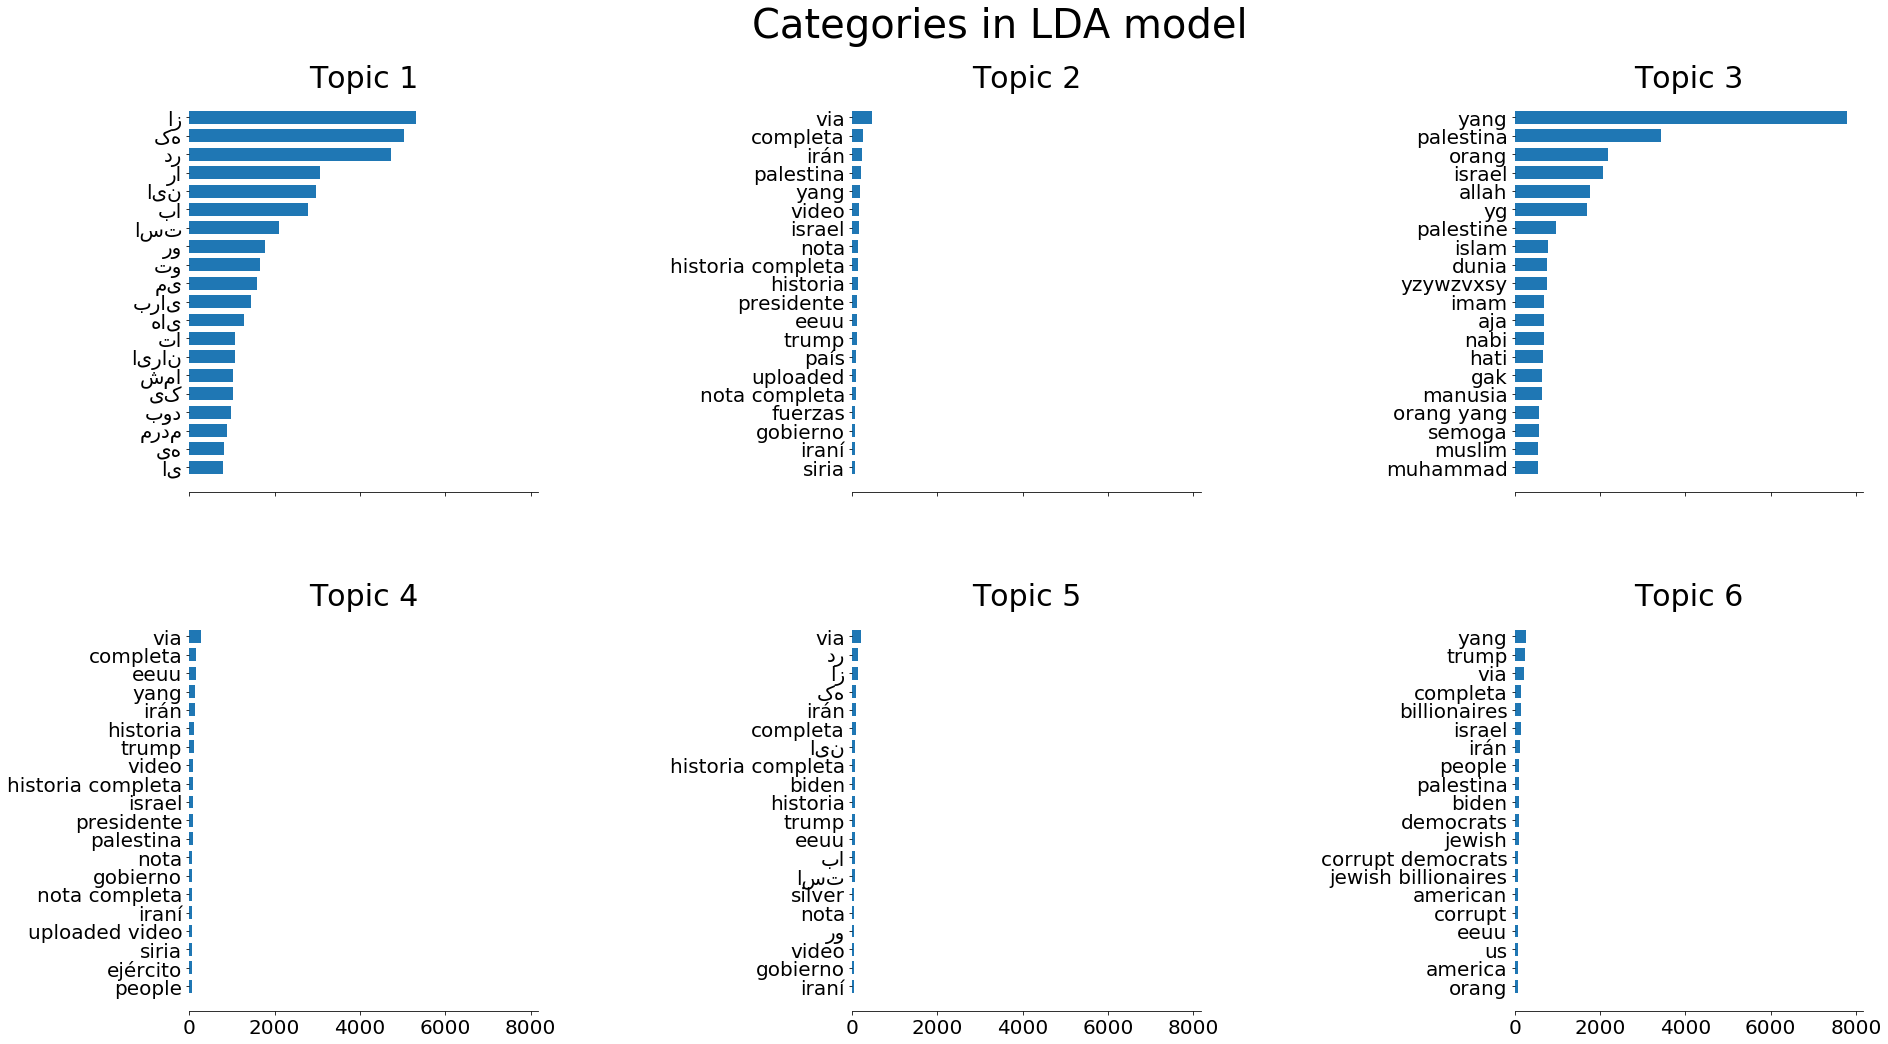

<Figure size 432x288 with 0 Axes>

In [34]:
tf_feature_names = vectorizer.get_feature_names()

plot_top_words(lda, 
               tf_feature_names, 
               n_top_words, 
               6,
               'Categories in LDA model')
plt.tight_layout()

Because the "document" level used in this case was per-user tweet token aggregates, we can perhaps consider these topics to be analogous to categories of users, based on their overall tweet set. Considering this campaign was so long, it is likely that the specific topics of tweets changed over time, so in further analysis, we might perform more filtering of the tweets in advance of clustering, for instance isolating tweets from a certain period of time.

In [35]:
"""Variational parameters for topic word distribution. 

Since the complete conditional for topic word distribution is a 
Dirichlet, components_[i, j] can be viewed as pseudocount that 
represents the number of times word j was assigned to topic i. 
It can also be viewed as distribution over the words for each 
topic after normalization: 
model.components_ / model.components_.sum(axis=1)[:, np.newaxis].
"""
lda.components_

array([[0.68801789, 0.60866241, 0.68842191, ..., 0.5889732 , 0.62284437,
        0.67410103],
       [0.60629299, 0.59361979, 0.64801018, ..., 0.60499627, 0.54382203,
        0.53741211],
       [1.45651894, 0.92475835, 1.18619684, ..., 0.7047135 , 0.72234893,
        0.62600304],
       ...,
       [0.57278512, 0.64634551, 0.58263569, ..., 0.60296245, 0.5853034 ,
        0.49451583],
       [0.54191633, 0.52692685, 0.61830417, ..., 0.61510437, 0.63087608,
        0.6324083 ],
       [0.51576177, 0.5560175 , 0.55186099, ..., 0.58113589, 0.5601597 ,
        0.63211518]])

In [36]:
def extract_topics(documents,
                   vectorizer=None,
                   n_samples=2000,
                   n_features=1000,
                   n_components=10,
                   n_top_words=20,
                   apply_preprocessing=True,
                   stop_words=None,
                   ):
    
    tokenize_partial = functools.partial(tokenize_string, stop_words=stop_words)
    preprocess_partial = functools.partial(preprocess_string, special_tokens=False)
    
    if stop_words == None:
        stop_words = [*stopwords.words(),
                      '[url]', '[at]', '[htag]',]
    if vectorizer == None:
        tokenize_partial = functools.partial(tokenize_string, 
                                             stop_words=stop_words)
        preprocess_partial = functools.partial(preprocess_string, 
                                               special_tokens=False)
        vectorizer = CountVectorizer(analyzer='word',
                             strip_accents='ascii',
                             stop_words=stop_words,
                             ngram_range=(1,2),
                             preprocessor=preprocess_partial,
                             tokenizer=tokenize_partial,
                            )
    if apply_preprocessing:
        documents = (documents
                          .map(long_string)
                          .map(preprocess_string)
                         )

    print('vectorizing...')
    tf = vectorizer.fit_transform(documents)
        
    
    print(('LDA:\nn_samples: {}\nn_features: {}\nn_components: {}')
          .format(n_samples, n_features, n_components))

    lda = LatentDirichletAllocation(n_components=n_components, 
                                    max_iter=5,
                                    learning_method='online',
                                    learning_offset=50.,
                                    random_state=0)

    lda.fit(tf)
    
    tf_feature_names = vectorizer.get_feature_names()

    plot_top_words(lda, 
                   tf_feature_names, 
                   n_top_words,
                   n_components,
                   'Categories in LDA model')
    plt.tight_layout()

vectorizing...
LDA:
n_samples: 2000
n_features: 1000
n_components: 6


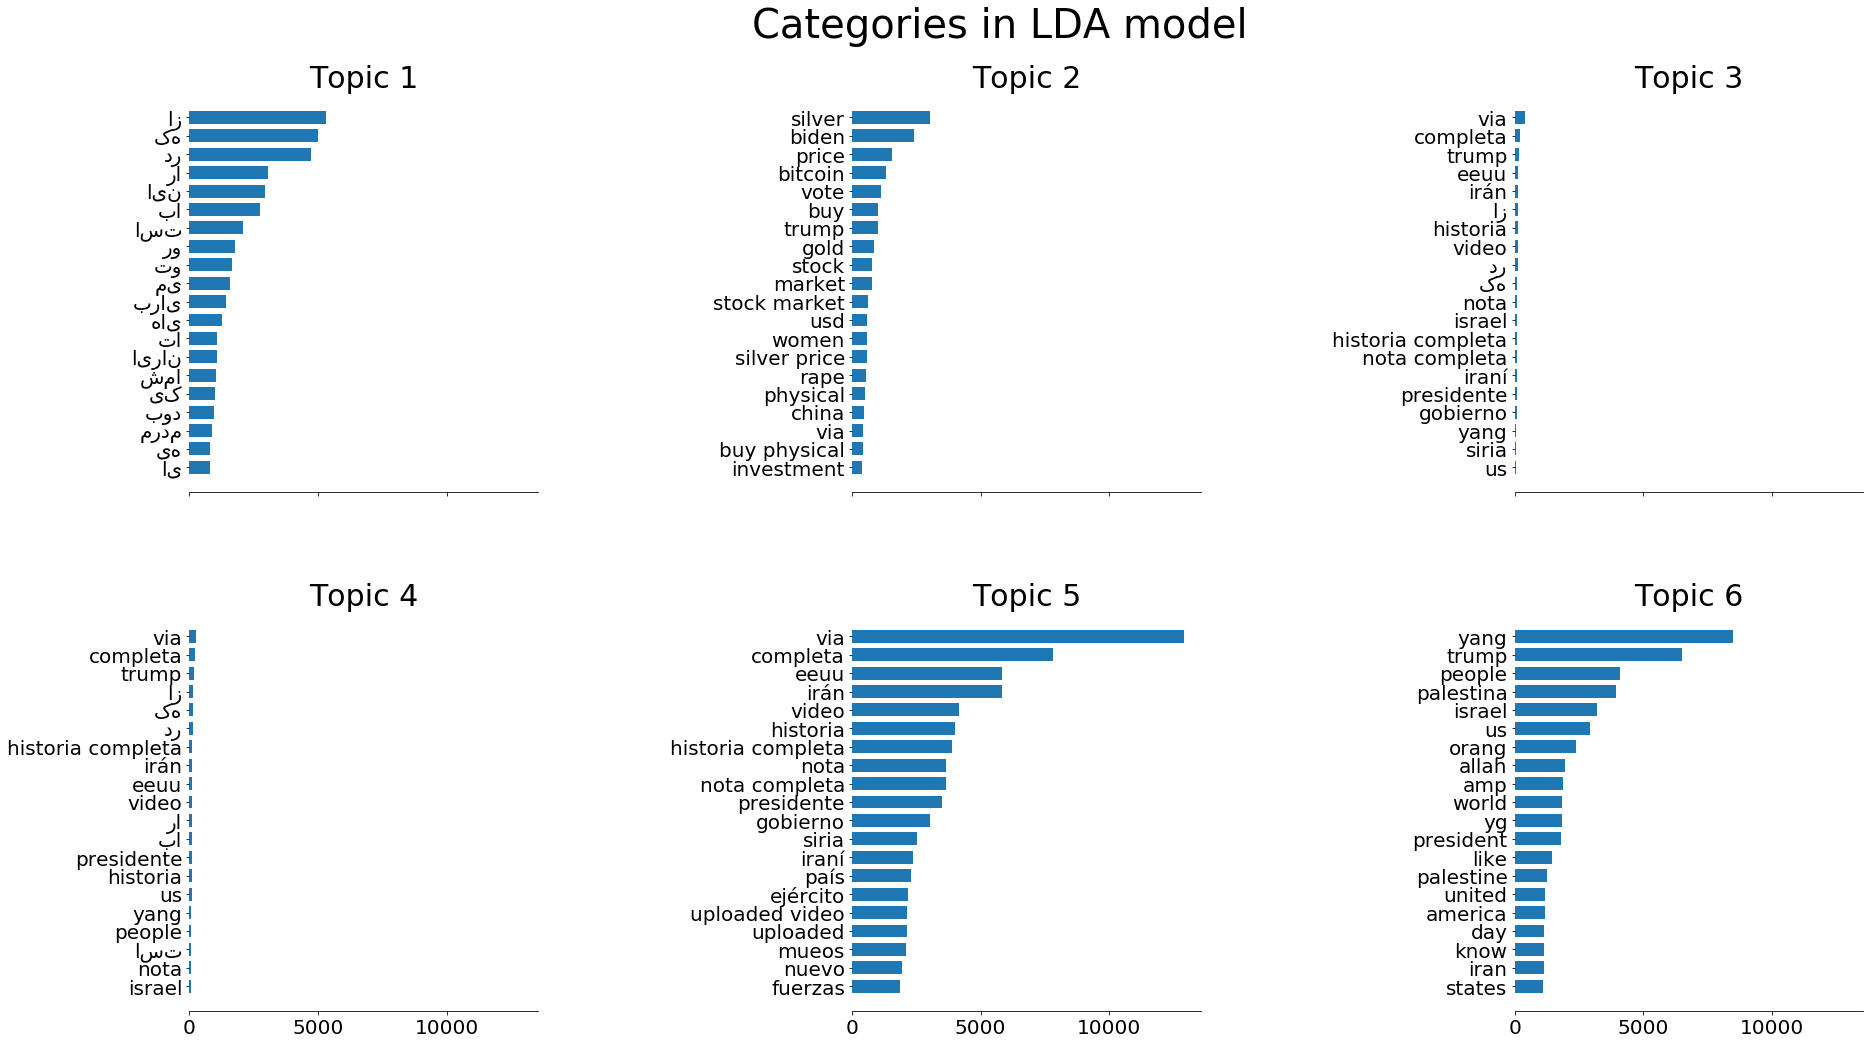

<Figure size 432x288 with 0 Axes>

In [37]:
extract_topics(user_tweets['tweet_text'],
               n_components=6)